# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from reproject import reproject_interp
from scipy.interpolate import interp1d
import copy

from minot.ClusterTools import map_tools
import pitszi

import macsj0717_libs as libs

sigma2fwhm = 2 * np.sqrt(2*np.log(2))

# Parameters

In [2]:
outdir = '/Users/adam/Project/Notes-Papier-Conf/2024_07_PITSZI_MACSJ0717/outputs/'

# Cluster parameters
cl_redshift = 0.546
cl_M500     = 20*1e14*u.Msun
cl_coord    = SkyCoord(109.3806*u.deg, 37.7583*u.deg, frame='icrs')

# Sampling
reso = 4*u.arcsec
FoV  = 4*u.arcmin
los_reso = 30*u.kpc
los_size = 10*u.Mpc

# Analysis parameters
ps_mask_lim = 0.1*100 # mJy
mask_theta = 2*u.arcmin
Nsim = 1000
apply_radial_model = True

# Get the data

In [3]:
#===== Instrument parameters
beam_FWHM    = 18.2*u.arcsec
FoV_diameter = 2*u.arcmin
TF = libs.get_TF()

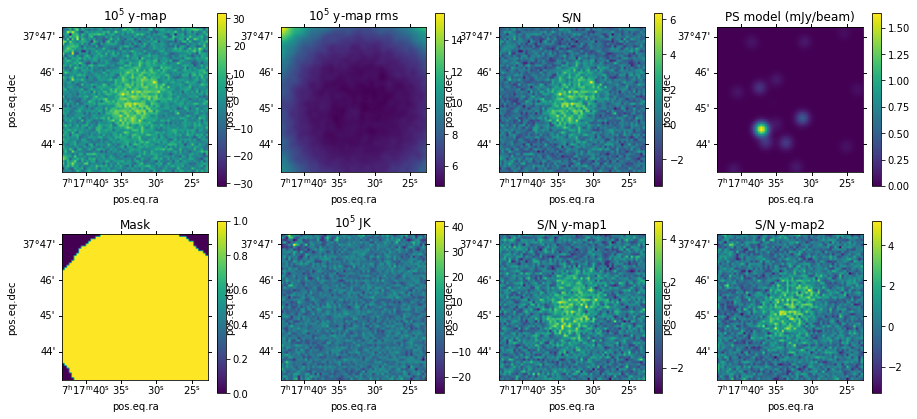

In [4]:
#===== Get the data
cl_head, y2jy, cl_img, cl_img1, cl_img2, cl_jk, cl_ps, cl_rms, cl_noise, cl_mask = libs.extract_data(FoV, reso, 
                                                                                                     ps_mask_lim,
                                                                                                     show=True)

# Define the model, data and inference

In [5]:
#========== cluster data
cl_data  = libs.def_data(cl_img,  cl_head, cl_noise, cl_mask, beam_FWHM, TF, outdir, Nsim)

In [6]:
#========== cluster model
cl_model = pitszi.Model(name='Model', RA=cl_coord.ra, Dec=cl_coord.dec, 
                        redshift=cl_redshift, M500=cl_M500, 
                        silent=True, output_dir=outdir)
cl_model.set_pressure_profile_universal_param('A10MD')
cl_model.map_header = cl_head
cl_model.los_reso  = los_reso
cl_model.los_size  = los_size
cl_model.R_truncation = 10*u.Mpc

In [7]:
#========== Inference radial
cl_Rinfer1 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit1/')
cl_Rinfer2 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit2/')
cl_Rinfer3 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit3/')
cl_Rinfer4 = pitszi.InferenceRadial(cl_data, cl_model, method_use_covmat=False, silent=False, output_dir=outdir+'/RadialFit4/')

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                    Radial Inference                        
------------------------------------------------------------
                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                    Radi

# Fit the smooth model to the data

In [8]:
#========== Curvefit the profile case 1
RA  = cl_Rinfer1.model.coord.ra
Dec = cl_Rinfer1.model.coord.dec
fitpar_prof = {
'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
'RA': {'guess':[RA.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[RA.to_value('deg')-0.5/60, RA.to_value('deg')+0.5/60]},
'Dec': {'guess':[Dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[Dec.to_value('deg')-0.5/60, Dec.to_value('deg')+0.5/60]},
'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
'ZL':{'guess':[0,1e-5],'unit':None},
}

plist, popt, pcov = cl_Rinfer1.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (M500): 
   median   = 26.468834152662776 -0.8941359901218426 +0.8797365736637417
   best-fit = 26.475161273854113 -0.9004631113131794 +0.873409452472405
   M500 = 26.468834152662776_{-0.8941359901218426}^{0.8797365736637417}
param 1 (RA): 
   median   = 109.38687643751459 -0.0003661294731216458 +0.0003520851225999877
   best-fit = 109.38699491845968 -0.000484610418212128 +0.00023360417750950546
   RA = 109.38687643751459_{-0.0003661294731216458}^{0.0003520851225999877}
param 2 (Dec): 
   median   = 37.75300958566268 -0.0003478473401514748 +0.00034802244467613264
   best-fit = 37.753581941878394 -0.0009202035558644184 +-0.00022433377103681096
   Dec = 37.75300958566268_{-0.0003478473401514748}^{0.00034802244467613264}
param 3 (min_to_maj_axis_ratio): 
   median   = 0.7811485935960036 -0.025995858128042393 +0.02673439568294267
   best-fit = 0.8082629485789824 -0.053110213111021154 +-0.00037995930003609235
   min_to_maj_axis_ratio = 0.7811485935960036_{-0.025995858128042393}^{0.0

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [9]:
#========== Curvefit the profile case 2
fitpar_prof = {
'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10UPP'},
'ZL':{'guess':[0,1e-5],'unit':None},
}
plist, popt, pcov = cl_Rinfer2.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (M500): 
   median   = 14.222822843984211 -0.34101353839107595 +0.34245620968405
   best-fit = 14.223906790381864 -0.34209748478872903 +0.3413722632863969
   M500 = 14.222822843984211_{-0.34101353839107595}^{0.34245620968405}
param 1 (ZL): 
   median   = 1.902084026253141e-05 -9.63102224817323e-07 +1.0273173346319695e-06
   best-fit = 1.795156872449946e-05 --1.0616931321462788e-07 +2.0965888726639204e-06
   ZL = 1.902084026253141e-05_{-9.63102224817323e-07}^{1.0273173346319695e-06}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [10]:
#========== Curvefit the profile case 3
RA  = cl_Rinfer3.model.coord.ra
Dec = cl_Rinfer3.model.coord.dec

fitpar_prof = {
'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
'RA': {'guess':[RA.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[RA.to_value('deg')-0.5/60, RA.to_value('deg')+0.5/60]},
'Dec': {'guess':[Dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[Dec.to_value('deg')-0.5/60, Dec.to_value('deg')+0.5/60]},
'ZL':{'guess':[0,1e-5],'unit':None},
}

plist, popt, pcov = cl_Rinfer3.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (M500): 
   median   = 21.641229649320678 -0.521388823075096 +0.5333053996638917
   best-fit = 21.637454065099668 -0.5176132388540857 +0.537080983884902
   M500 = 21.641229649320678_{-0.521388823075096}^{0.5333053996638917}
param 1 (RA): 
   median   = 109.38705029975188 -0.00039829202243879536 +0.00038593920160678863
   best-fit = 109.3865974474446 --5.4560284837634754e-05 +0.0008387915088832187
   RA = 109.38705029975188_{-0.00039829202243879536}^{0.00038593920160678863}
param 2 (Dec): 
   median   = 37.75300288728793 -0.0003198752541280214 +0.0003138904807400422
   best-fit = 37.752898285553655 -0.00021527351985639598 +0.00041849221501166767
   Dec = 37.75300288728793_{-0.0003198752541280214}^{0.0003138904807400422}
param 3 (ZL): 
   median   = 1.593202011842704e-05 -1.0123079345506593e-06 +9.935366731813881e-07
   best-fit = 1.5870231632174103e-05 -9.505194482977209e-07 +1.0553251594343265e-06
   ZL = 1.593202011842704e-05_{-1.0123079345506593e-06}^{9.935366731813881e-07}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [11]:
#========== Curvefit the profile
RA  = cl_Rinfer4.model.coord.ra
Dec = cl_Rinfer4.model.coord.dec

fitpar_prof = {
'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
'b': {'guess':[5, 0.5], 'unit': None, 'limit':[2, 8]},
'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[0, 2]},
'RA': {'guess':[RA.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[RA.to_value('deg')-0.5/60, RA.to_value('deg')+0.5/60]},
'Dec': {'guess':[Dec.to_value('deg'), 0.5/60], 'unit': u.deg, 'limit':[Dec.to_value('deg')-0.5/60, Dec.to_value('deg')+0.5/60]},
'min_to_maj_axis_ratio':{'guess':[0.5,0.1], 'unit':None, 'limit':[0,1]}, 
'angle':{'guess':[20,10], 'unit':u.deg, 'limit':[-90,90]},
'ZL':{'guess':[0,1e-5],'unit':None},
}

plist, popt, pcov = cl_Rinfer4.run_curvefit_profile(fitpar_prof, 
                                                    show_fit_result=True, 
                                                    set_bestfit=True)

param 0 (P_0): 
   median   = 0.10117731134328456 -0.012082830204022774 +0.009344266383541841
   best-fit = 0.09730912636390923 -0.008214645224647446 +0.013212451362917169
   P_0 = 0.10117731134328456_{-0.012082830204022774}^{0.009344266383541841}
param 1 (r_p): 
   median   = 428.2098826940247 -35.881104008863986 +28.421041491176936
   best-fit = 463.667616839633 -71.33883815447228 +-7.036692654431363
   r_p = 428.2098826940247_{-35.881104008863986}^{28.421041491176936}
param 2 (a): 
   median   = 8.585420037486717 -1.4191999805226185 +0.9946235598484972
   best-fit = 7.760362201119184 -0.5941421441550858 +1.8196813962160299
   a = 8.585420037486717_{-1.4191999805226185}^{0.9946235598484972}
param 3 (b): 
   median   = 6.159731119929184 -1.8769919809021456 +1.2606056847778264
   best-fit = 7.705005307158254 -3.422266168131216 +-0.2846685024512441
   b = 6.159731119929184_{-1.8769919809021456}^{1.2606056847778264}
param 4 (c): 
   median   = 0.12298773121483014 -0.08593240199690598 +0.

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


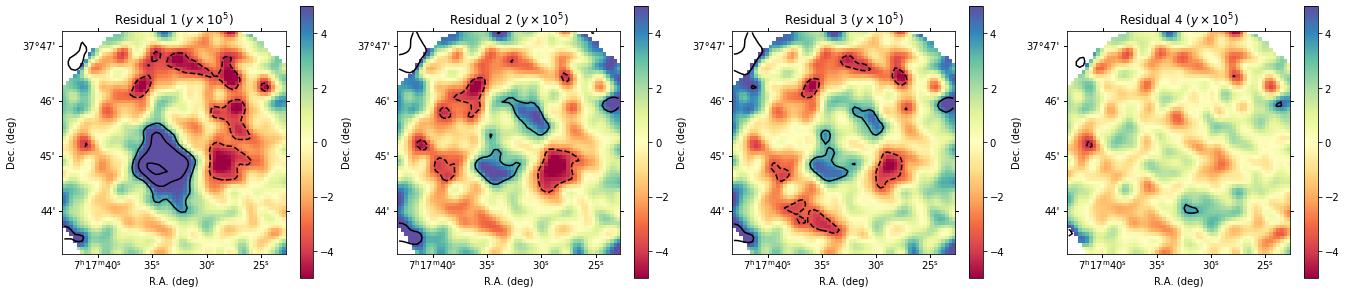

In [13]:
#===== Show the images

smooth_FWHM = 15*u.arcsec

# Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(23, 5))
model_sph1 = cl_Rinfer1.get_radial_model()
model_sph2 = cl_Rinfer2.get_radial_model()
model_sph3 = cl_Rinfer3.get_radial_model()
model_sph4 = cl_Rinfer4.get_radial_model()
    
rms = cl_data.get_noise_rms_from_model(Nmc=Nsim, smooth_fwhm=smooth_FWHM)
rms = gaussian_filter(rms, sigma=10/3600/sigma2fwhm/cl_head['CDELT2'])
    
rng = [-5,5]

msk = copy.deepcopy(cl_data.mask)
msk[cl_data.mask == 0] = np.nan
    
#----- Residual 1
ax = plt.subplot(1, 4, 1, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph2, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph2, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 1 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')
    
#----- Cluster model
ax = plt.subplot(1, 4, 2, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph3, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph3, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 2 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Residual model
ax = plt.subplot(1, 4, 3, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph1, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph1, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 3 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

#----- Residual model
ax = plt.subplot(1, 4, 4, projection=WCS(cl_head))
plt.imshow(msk*gaussian_filter(cl_img - model_sph4, 
                               sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])*1e5, 
           cmap='Spectral', vmin=rng[0], vmax=rng[1])
cb = plt.colorbar()
plt.contour(gaussian_filter(cl_img - model_sph4, 
                            sigma=smooth_FWHM.to_value('deg')/sigma2fwhm/cl_head['CDELT2'])/rms, 
            levels=[-6,-3,3,6,9,12,15,18,21], colors='k')
plt.title(r'Residual 4 ($y \times 10^5$)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

plt.savefig(outdir+'/RadialFit_residuals.pdf')